In [23]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM,Flatten,Dropout,Embedding,Softmax,Bidirectional
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
Dataset_train = pd.read_csv('train.tsv',sep='\t')
Dataset_test = pd.read_csv('test.tsv',sep='\t')
sampleSubmission = pd.read_csv('sampleSubmission.csv')

In [3]:
Dataset_train.sample(6)

,PhraseId,SentenceId,Phrase,Sentiment
109945,109946,5824,it 's semi-amusing to watch Robert DeNiro belt...,2
154301,154302,8432,into heaven,3
27898,27899,1281,impatiently,2
142316,142317,7720,of average people,2
89894,89895,4678,that sentiment,2
103562,103563,5461,takes every potential laugh and stiletto-stomp...,0


In [4]:
# 0-nagative , 1-somewhat negative , 2-neutral , 3-somewhat positive , 4-positive

In [5]:
Dataset_train.drop(['PhraseId','SentenceId'],axis=1,inplace=True)
Dataset_test.drop(['PhraseId','SentenceId'],axis=1,inplace=True)

In [6]:
Dataset_train.head(3)

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2


# cleaning text

In [7]:
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in forbidden_words]
        return " ".join(text)
    return ""

In [8]:
Dataset_train['Phrase'] = Dataset_train.apply(lambda row: text_cleaning(row['Phrase']),axis=1)
Dataset_test['Phrase'] = Dataset_test.apply(lambda row: text_cleaning(row['Phrase']),axis=1)

# tokenize (字轉數字)

In [9]:
List_train = Dataset_train['Phrase'].to_list()
List_test = Dataset_test['Phrase'].to_list()

In [10]:
#最長鋸子的長度 =>padding會用到
#總共有多少個unique的文字
unique_words = set()
maximum_sentence_lenth = 0
for sentence in tqdm(List_train):
    sentence_split = sentence.split()
    if len(sentence_split) > maximum_sentence_lenth:
        maximum_sentence_lenth = len(sentence_split)
    for words in sentence_split:
        unique_words.update([words])

100%|█████████████████████████████████████████████████████████████████████| 156060/156060 [00:00<00:00, 1174434.92it/s]


In [11]:
print(f'最長句子有:{maximum_sentence_lenth}個單字\n總共有{len(unique_words)}個unique單字')

最長句子有:30個單字
總共有14993個unique單字


In [12]:
tokenizer = Tokenizer(num_words=len(unique_words))
tokenizer.fit_on_texts(List_train)

In [13]:
tokenizer.word_index

{'film': 1,
 'movie': 2,
 'n': 3,
 'one': 4,
 'like': 5,
 'story': 6,
 'rrb': 7,
 'good': 8,
 'lrb': 9,
 'time': 10,
 'characters': 11,
 'much': 12,
 'comedy': 13,
 'life': 14,
 'even': 15,
 'little': 16,
 'funny': 17,
 'well': 18,
 'way': 19,
 'make': 20,
 'movies': 21,
 'director': 22,
 'love': 23,
 'new': 24,
 'bad': 25,
 'work': 26,
 'enough': 27,
 'us': 28,
 'made': 29,
 'old': 30,
 'action': 31,
 'two': 32,
 'something': 33,
 'would': 34,
 'best': 35,
 'never': 36,
 'many': 37,
 'people': 38,
 'self': 39,
 'makes': 40,
 'character': 41,
 'world': 42,
 'first': 43,
 'may': 44,
 'plot': 45,
 'see': 46,
 'films': 47,
 'drama': 48,
 'could': 49,
 'better': 50,
 'audience': 51,
 'long': 52,
 'look': 53,
 'big': 54,
 'sense': 55,
 'really': 56,
 'man': 57,
 'feel': 58,
 'without': 59,
 'real': 60,
 'great': 61,
 'every': 62,
 'humor': 63,
 'ever': 64,
 'screen': 65,
 'year': 66,
 'another': 67,
 'minutes': 68,
 'get': 69,
 'hollywood': 70,
 'still': 71,
 'performances': 72,
 'cast': 73

In [14]:
Sequences_train = tokenizer.texts_to_sequences(List_train)
Sequences_test =tokenizer.texts_to_sequences(List_test)

# Padding

In [15]:
PS_train = pad_sequences(Sequences_train,maxlen=maximum_sentence_lenth)
PS_test = pad_sequences(Sequences_test,maxlen=maximum_sentence_lenth)

In [16]:
X_train = PS_train
y_train = Dataset_train['Sentiment']

#split validation
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2)

In [17]:
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((124848, 30), (31212, 30), (124848,), (31212,))

In [18]:
X_train

array([[    0,     0,     0, ...,  6224,   340,    90],
       [    0,     0,     0, ...,     0,  5904,  6799],
       [    0,     0,     0, ..., 13260, 12443,    81],
       ...,
       [    0,     0,     0, ...,     0,  3332,   167],
       [    0,     0,     0, ...,  4882,  6031,   993],
       [    0,     0,     0, ...,     0,     0, 10050]])

# Train model

In [19]:
LSTM_Model = tf.keras.models.Sequential([
    
    Embedding(len(list(unique_words)), 128, input_length=maximum_sentence_lenth),
    
    Bidirectional(LSTM(
        units=256,
        activation='tanh',
        return_sequences=True,
        dropout=0.5,
        kernel_regularizer= l2(1e-2),
        recurrent_regularizer= l2(1e-3)
    )),
    
    Bidirectional(LSTM(
        units=256,
        activation='tanh',
        return_sequences=False,
        dropout=0.5,
        kernel_regularizer= l2(1e-2),
        recurrent_regularizer= l2(1e-3)
    )),
    
    
    Dense(128,activation='relu'),
    
    Dense(5,activation='softmax')
])

LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           1919104   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 512)          788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 4,348,805
Trainable params: 4,348,805
Non-

In [20]:
Batch_size = 256
Num_of_Epoch = 50

Optimizer_Adam = tf.keras.optimizers.Adam(learning_rate = 1e-3)

Loss_Function = tf.keras.losses.SparseCategoricalCrossentropy()

LSTM_Model.compile(optimizer=Optimizer_Adam,loss=Loss_Function,metrics=['accuracy'])

#學習率排程
def scheduler(epoch,lr):
    if epoch < 25 :
        return lr
    else:
        return lr*tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

History = LSTM_Model.fit(x=X_train, 
                         y=y_train,
                         batch_size=Batch_size,
                         epochs=Num_of_Epoch,
                         validation_data=(X_valid,y_valid),
                         callbacks=[callback]
                        )

Epoch 1/50
488/488 [==============================] - 23s 38ms/step - loss: 1.9354 - accuracy: 0.5381 - val_loss: 1.1137 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 2/50
488/488 [==============================] - 17s 36ms/step - loss: 1.0775 - accuracy: 0.5737 - val_loss: 1.1028 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 3/50
488/488 [==============================] - 17s 36ms/step - loss: 1.0409 - accuracy: 0.5886 - val_loss: 1.0833 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 4/50
488/488 [==============================] - 17s 35ms/step - loss: 1.0206 - accuracy: 0.5983 - val_loss: 1.0630 - val_accuracy: 0.5791 - lr: 0.0010
Epoch 5/50
488/488 [==============================] - 17s 35ms/step - loss: 1.0091 - accuracy: 0.6035 - val_loss: 1.0629 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 6/50
488/488 [==============================] - 17s 35ms/step - loss: 0.9981 - accuracy: 0.6088 - val_loss: 1.0653 - val_accuracy: 0.5796 - lr: 0.0010
Epoch 7/50
488/488 [==============================] - 17s 

In [21]:
loss = History.history["loss"]
accuracy = History.history["accuracy"]
val_loss = History.history["val_loss"]
val_accuracy = History.history["val_accuracy"]

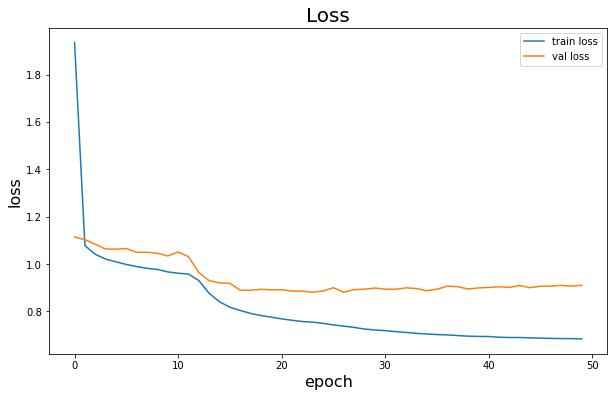

In [24]:
# loss
plt.figure(figsize=(10,6))
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend()
plt.show()

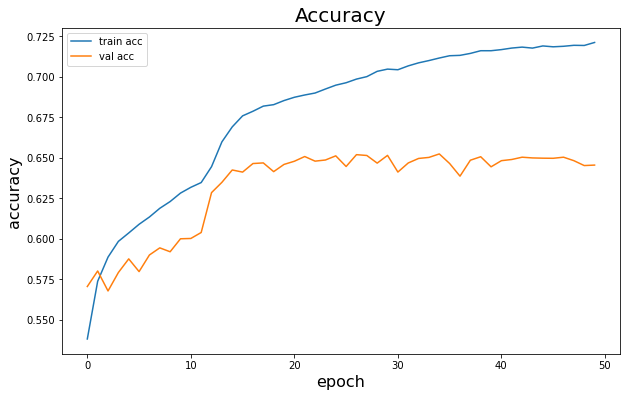

In [25]:
# accuracy
plt.figure(figsize=(10,6))
plt.plot(accuracy, label="train acc")
plt.plot(val_accuracy, label="val acc")
plt.title("Accuracy", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend()
plt.show()


In [26]:
PS_test

array([[   0,    0,    0, ...,  497,  900,  284],
       [   0,    0,    0, ...,  497,  900,  284],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,   52, 5728],
       [   0,    0,    0, ...,    0,   52, 5728],
       [   0,    0,    0, ...,    0,  265, 1874]])

In [29]:
y_pred=LSTM_Model.predict(PS_test)

2072/2072 [==============================] - 13s 6ms/step


In [30]:
y_pred = np.argmax(y_pred,axis=1)

In [31]:
sub = pd.read_csv('sampleSubmission.csv')
sub

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [32]:
sub['Sentiment']=y_pred

In [33]:
sub.to_csv('for_sub(token).csv',index=False)

In [34]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 1991, 10162, 38491, 12750,  2898], dtype=int64))